<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-cases" data-toc-modified-id="Load-cases-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Load cases</a></span></li></ul></li></ul></li></ul></div>

# Learning Generation - Part 2

Now let's reincorporate line capacity constraints.

In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Distributions, Random
using LinearAlgebra
using Plots

using Revise
using CarbonNetworks

# Load data

### Load network

In [815]:
DATAPATH = "/Users/apple/Documents/REU/carbon_data"
num_generators = 1
A, B, gmax, pmax, f, G, nodes, gen_labels = parse_network_data(DATAPATH; num_generators)
n, m = size(A)
n, l = size(B)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization
pmax_increase = 100
pmax .+= pmax_increase
@show n, m

agg_generators, M = create_generation_map(gen_labels)

(n, m) = (76, 167)


(Any[(1, "COL"), (2, "COL"), (3, "COL"), (4, "COL"), (5, "COL"), (6, "COL"), (7, "COL"), (8, "COL"), (9, "COL"), (10, "COL")  …  (67, "OIL"), (68, "OIL"), (69, "OIL"), (70, "OIL"), (71, "OIL"), (72, "OIL"), (73, "OIL"), (74, "OIL"), (75, "OIL"), (76, "OIL")], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

### Load cases

In [812]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))


cases = []
for file in file_names[1:500]   
    d, g, case = load_case(file, B, agg_generators)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_size = 10
test_size = 5

train_cases = cases[1:train_size]
test_cases = cases[train_size+1:train_size+test_size];

# Initialize

In [813]:
# Seeds that seem to work: 706
seed = rand(1:1_000)
Random.seed!(seed)
@show seed

# Initialize estimated costs
f̂q = max.(1.0, 10 .+ randn(l)) 
f̂l = max.(1.0, 10 .+ randn(l)) 
mean_est_cost = mean(f̂q)
@show norm(f̂q), norm(f̂l)

train_loss_hist = []
test_loss_hist = []
grad_hist = []

seed = 606
(norm(f̂q), norm(f̂l)) = (248.7003444559853, 247.60805918322808)


Any[]

In [814]:
f̂q

608-element Vector{Float64}:
  9.575014112790134
 10.82159775290879
 10.44202158424196
 10.588089429863498
 10.462070554182993
  9.757038568550042
 11.187380696628805
  9.32355901875181
  9.819209536559582
 10.930235302744642
 10.224669805303984
  9.452767995493515
 11.547389548272063
  ⋮
  8.547999744239032
 10.270069852765493
  9.456789769900611
 10.204645068503874
 11.681389273828216
 10.26232821067964
  8.137787426089522
  9.368044784970746
  9.629389224775107
  9.861350504577015
 10.074595263712506
  9.774730346458675

# Fit

In [804]:
# Algorithm parameters
step_size = 1
max_iter = 200
batch_size = 8
test_batch_size = 8
gradient_scale = 1

1

In [805]:

@time for iter in 1:max_iter
    if mod(iter, 50) == 0
        print("$(iter)-")
    end
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(sample, train_cases, f̂q, f̂l, M, pmax, gmax, A, B)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _, _ = stochastic_loss_and_grad(sample, test_cases, f̂q, f̂l, M, pmax, gmax, A, B)
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    η = gradient_scale * min(norm(dfq), step_size)
    f̂q = max.(f̂q - η*(dfq/norm(dfq)), 1)
    
    η = gradient_scale * min(norm(dfl), step_size)
    f̂l = max.(f̂l - η*(dfl/norm(dfl)), 1)
end

min_train_loss = minimum(train_loss_hist)
min_test_loss = minimum(test_loss_hist)
min_train_grad = minimum(norm.(grad_hist))
@show norm(f̂q)
@show min_train_loss
println("Completed $(max_iter) iterations.")

50-100-150-200-113.570177 seconds (64.95 M allocations: 36.146 GiB, 4.34% gc time)
norm(f̂q) = 176.30488796916273
min_train_loss = 0.10488709510679099
Completed 200 iterations.


minimum(norm.(grad_hist)) = 5.175383332030189


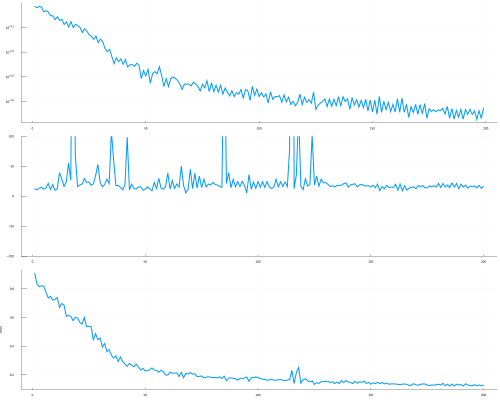

In [809]:
theme(:default, lw=4, label=nothing)
best_so_far(x) = [minimum(x[1:k]) for k in 1:length(x)]
rolling_avg(x, lag) = [mean(x[i:i+lag-1]) for i in 1:(length(x)-lag)]
@show minimum(norm.(grad_hist))

Δhist = [dfq[100] for dfq in grad_hist]
Δhist = norm.(grad_hist)

plt = plot(
    plot(rolling_avg(train_loss_hist, 1), ylabel="train", yscale = :log10),
    plot(Δhist, ylabel="grad hist", ylim=(-100, 100)),
    plot(test_loss_hist, ylabel="test"),
    layout=(3, 1),
    size = (2000,1600)
)

In [752]:
# Initialize records
records = DataFrame(
    trial = Int[],
    num_generators = Int[], 
    step_size = Float16[],
    gradient_scale = Float16[],
    max_iter = Int[],
    success = Bool[],
    min_train_loss = Float16[],
    min_test_loss = Float16[],
    min_train_grad = Float16[],
    batch_size = Int[],
    test_batch_size = Int[],
    train_size = Int[], 
    test_size = Int[],
    pmax_increase = Float16[], 
    )
push!(records, (1,1,1.0,1.0,1,true,1.0,1.0,1.0,1,1,1,1,1.0))
CSV.write("/Users/apple/Documents/GitHub/CarbonNetworks.jl/graphs/records.csv", records)

"/Users/apple/Documents/GitHub/CarbonNetworks.jl/graphs/records.csv"

In [807]:
# Save records
records_file = DataFrame(CSV.File("/Users/apple/Documents/GitHub/CarbonNetworks.jl/graphs/records.csv"))
trial = nrow(records_file) + 1
push!(records_file,(trial, num_generators,step_size, gradient_scale, max_iter,
        success=true,
        min_train_loss, min_test_loss, min_train_grad, batch_size, test_batch_size, train_size,test_size,pmax_increase))
CSV.write("/Users/apple/Documents/GitHub/CarbonNetworks.jl/graphs/records.csv", records_file)
location = "/Users/apple/Documents/GitHub/CarbonNetworks.jl/graphs" * "/graph_" * string(trial) * ".png"
savefig(plt, location)

In [808]:
print(records_file)

7×14 DataFrame
 Row │ trial  num_generators  step_size  gradient_scale  max_iter  success  min_train_loss  min_test_loss  min_train_grad  batch_size  test_batch_size  train_size  test_size  pmax_increase 
     │ Int64  Int64           Float64    Float64         Int64     Bool     Float64         Float64        Float64         Int64       Int64            Int64       Int64      Float64       
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1               1        1.0             1.0         1     true       1.0            1.0               1.0               1                1           1          1            1.0
   2 │     2               3        1.0             1.0       500     true       1.25387        1.38035          34.3391            8                8          50          1          100.0
   3 │     3               1        1

┌ Info: Saved animation to 
│   fn = /Users/apple/Documents/GitHub/CarbonNetworks.jl/notebooks/tmp.gif
└ @ Plots /Users/apple/.julia/packages/Plots/iYDwd/src/animation.jl:104


Plots.AnimatedGif("/Users/apple/Documents/GitHub/CarbonNetworks.jl/notebooks/tmp.gif")
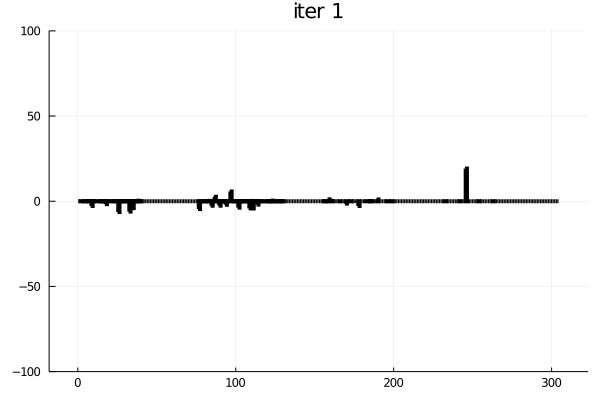

In [329]:
@gif for iter in 1:500
    iter = ceil(Int, iter / 5)
    bar(grad_hist[iter], ylim=(-100, 100), title="iter $iter")
end